## ICE 3

**Author**: Nicolas Dussaillant

**Instructor**: Dr. Lukas Liu

**Course**: HUDK4051 - Learning Analytics - Teachers College, Columbia University

## Work: Simulation of IRT

### Libraries

In [2]:
import pandas as pd
from pprint import pprint
import pystan
from scipy.special import expit
from matplotlib import pyplot as plt
from numpy.random import normal, randint, binomial, choice
from numpy import percentile, concatenate, array, linspace, append
%matplotlib inline

### Model Specifications

In [13]:
stan_model = """
data {
  // numbers of things
  int<lower=1> R;  // responses
  int<lower=1> I;  // items
  int<lower=1> S;  // subjects
  // data
  int<lower=1,upper=I> item[R];
  int<lower=1,upper=S> subject[R];
  int<lower=0,upper=1> grade[R];
}
parameters {
  // parameters
  vector[S] ability;
  vector[I] difficulty;
  // hyperparameters
  real mu_difficulty;
  real<lower=0> sigma_difficulty;
  real<lower=0> sigma_ability;
}
model {
  // priors
  ability ~ normal(0, sigma_ability);
  difficulty ~ normal(0, sigma_difficulty);
  mu_difficulty ~ cauchy(0, 5);
  // data model
  grade ~ bernoulli_logit(ability[subject] - difficulty[item] - mu_difficulty);
}
"""

### Data Simulation

In [14]:
def generate_binary_irt_data(sim_input):
    # simulate abilities, difficulties, and subject/item combinations
    sim_ability = normal(loc=0,
                         scale=sim_input['sigma_ability'],
                         size=sim_input['S'])
    sim_difficulty = normal(loc=sim_input['mu_difficulty'],
                            scale=sim_input['sigma_difficulty'],
                            size=sim_input['I'])
    sim_subject = randint(low=0,
                          high=sim_input['S'],
                          size=sim_input['R'])
    sim_item = randint(low=0,
                       high=sim_input['I'],
                       size=sim_input['R'])
    # work out success probabilities
    sim_success_probabilities = expit(sim_ability[sim_subject] -
                                      sim_difficulty[sim_item])
    # simulate grades
    sim_grade = binomial(n=1,
                         p=sim_success_probabilities,
                         size=sim_input['R'])
    # Dictionary of data to give to STAN
    sim_data = {
        'grade': sim_grade,
        'subject': sim_subject + 1,
        'item': sim_item + 1,
    }
    sim_data.update({i: binary_sim_input[i] for i in ['R', 'I', 'S']})
    recoverables = {
        'ability': sim_ability,
        'difficulty': sim_difficulty,
    }
    recoverables.update({i: binary_sim_input[i] for i in ['sigma_ability',
                                                          'mu_difficulty',
                                                          'sigma_difficulty']})
    return sim_data, recoverables

# define some input data
binary_sim_input = {'R': 10000,
                    'I': 15,
                    'S': 15,
                    'sigma_ability': 1,
                    'sigma_difficulty': 2,
                    'mu_difficulty': -1}
binary_sim_data, binary_sim_recoverables = generate_binary_irt_data(binary_sim_input)
# print results
print('Here is our randomly generated data:')
pprint(binary_sim_data)  # pprint makes the dictionary print nicely

Here is our randomly generated data:
{'I': 15,
 'R': 10000,
 'S': 15,
 'grade': array([1, 1, 1, ..., 0, 0, 0]),
 'item': array([ 5, 14,  4, ..., 15,  2,  3]),
 'subject': array([13,  7, 10, ...,  1,  2, 14])}


### Fit the IRT model

In [15]:
graded_irt_model = pystan.StanModel(model_code=stan_model)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_d17f30cbb8e48d88ba12ecb4e813d816 NOW.


Inference for Stan model: anon_model_d17f30cbb8e48d88ba12ecb4e813d816.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                   mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
ability[1]        -0.36    0.02   0.38  -1.11  -0.62  -0.37  -0.12   0.44    474   1.01
ability[2]         0.37    0.02   0.39  -0.38   0.12   0.35   0.62   1.19    486   1.01
ability[3]        -1.64    0.02   0.39  -2.39  -1.89  -1.65  -1.39  -0.83    482   1.01
ability[4]         1.99    0.02   0.39   1.24   1.73   1.98   2.24   2.81    512   1.01
ability[5]          0.1    0.02   0.39  -0.64  -0.16   0.09   0.35   0.92    478   1.01
ability[6]        -0.17    0.02   0.39  -0.93  -0.42  -0.18   0.08   0.64    482   1.01
ability[7]         0.55    0.02   0.39   -0.2   0.29   0.54    0.8   1.34    492   1.01
ability[8]         2.29    0.02    0.4   1.51   2.02   2.29   2.55   3.13    495   1.01
ability[9]        -

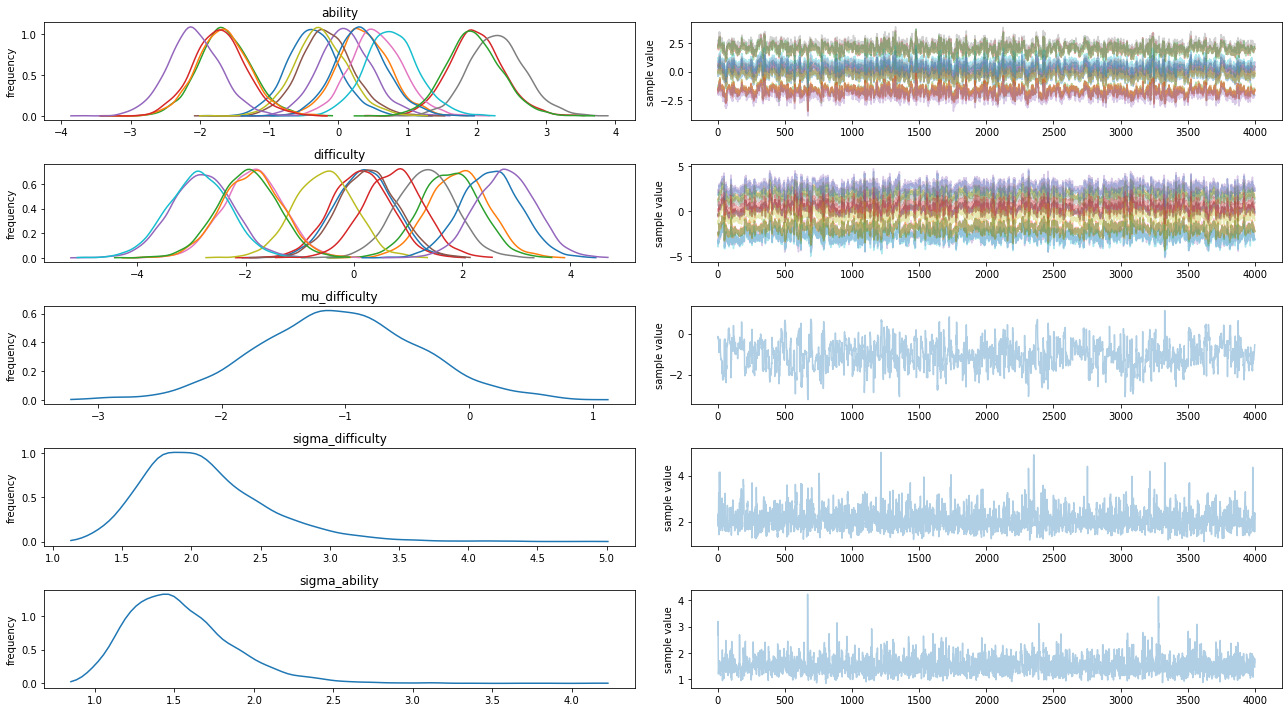

In [16]:
# fit model
binary_fit = graded_irt_model.sampling(data=binary_sim_data, iter=2000, chains=4)
# extract parameters
binary_params = binary_fit.extract()
# print fit summary
print(binary_fit)
# draw summary plot
f = binary_fit.plot()
f.set_size_inches(18, 10)
plt.tight_layout()